In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
from icedef import metocean

In [4]:
start_time = np.datetime64('2015-04-20T00:00:00')
end_time = np.datetime64('2015-04-21T00:00:00')

In [5]:
meto = metocean.Metocean((start_time, end_time))

In [6]:
lat_bounds = (49, 51)
lon_bounds = (-51, -49)
time_bounds = (start_time, end_time)

ocean_lat_idxs = np.where((meto.ocean.dataset.latitude > lat_bounds[0]) & \
                          (meto.ocean.dataset.latitude < lat_bounds[1]))[0]
ocean_lon_idxs = np.where((meto.ocean.dataset.longitude > lon_bounds[0]) & \
                          (meto.ocean.dataset.longitude < lon_bounds[1]))[0]
ocean_time_idxs = np.where((meto.ocean.dataset.time > time_bounds[0]) & \
                          (meto.ocean.dataset.time < time_bounds[1]))[0]
atm_lat_idxs = np.where((meto.atmosphere.dataset.lat > lat_bounds[0]) & \
                          (meto.atmosphere.dataset.lat < lat_bounds[1]))[0]
atm_lon_idxs = np.where((meto.atmosphere.dataset.lon > lon_bounds[0]) & \
                          (meto.atmosphere.dataset.lon < lon_bounds[1]))[0]
atm_time_idxs = np.where((meto.atmosphere.dataset.time > time_bounds[0]) & \
                          (meto.atmosphere.dataset.time < time_bounds[1]))[0]

uo = meto.ocean.eastward_current_velocities[ocean_time_idxs[0]:ocean_time_idxs[-1], 
                                           ocean_lat_idxs[0]:ocean_lat_idxs[-1],
                                           ocean_lon_idxs[0]:ocean_lon_idxs[-1]]

vo = meto.ocean.northward_current_velocities[ocean_time_idxs[0]:ocean_time_idxs[-1], 
                                           ocean_lat_idxs[0]:ocean_lat_idxs[-1],
                                           ocean_lon_idxs[0]:ocean_lon_idxs[-1]]

wo = np.sqrt(uo**2 + vo**2)

ua = meto.atmosphere.eastward_wind_velocities[atm_time_idxs[0]:atm_time_idxs[-1],
                                             atm_lat_idxs[0]:atm_lat_idxs[-1],
                                             atm_lon_idxs[0]:atm_lon_idxs[-1]]

va = meto.atmosphere.northward_wind_velocities[atm_time_idxs[0]:atm_time_idxs[-1],
                                             atm_lat_idxs[0]:atm_lat_idxs[-1],
                                             atm_lon_idxs[0]:atm_lon_idxs[-1]]

wa = np.sqrt(ua**2 + va**2)

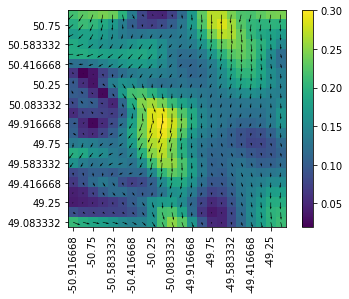

In [7]:
plt.imshow(wo[0,:,:], origin='lower')
plt.xticks(np.arange(0, len(wo.longitude), 2), wo.longitude.values[::2], rotation=90)
plt.yticks(np.arange(0, len(wo.latitude), 2), wo.latitude.values[::2])
plt.colorbar()
plt.quiver(uo[0,:,:], vo[0,:,:])

plt.show()

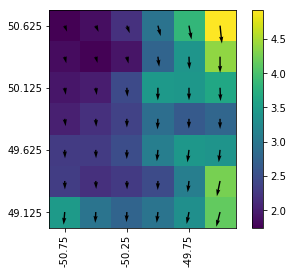

In [8]:
plt.imshow(wa[0,:,:], origin='lower')
plt.xticks(np.arange(0, len(wa.longitude), 2), wa.longitude.values[::2], rotation=90)
plt.yticks(np.arange(0, len(wa.latitude), 2), wa.latitude.values[::2])
plt.colorbar()
plt.quiver(ua[0,:,:], va[0,:,:])

plt.show()

In [75]:
x = np.zeros(len(wa[:,0,0]))
y = np.zeros(len(wa[:,0,0]))
x[0] = 0 #ua.longitude[0]
y[0] = 0 #ua.latitude[0]
for i in range(len(ua.longitude.values) - 1):
    x[i+1] = x[i] + np.mean(np.diff(ua.latitude.values)) / np.mean(np.diff(ua.longitude.values))
    y[i+1] = y[i] + np.mean(np.diff(ua.latitude.values)) / np.mean(np.diff(ua.longitude.values))

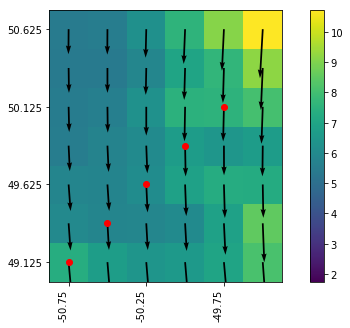

In [96]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'


fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(wa[0,:,:], origin='lower', animated=True, 
                vmin=min(wa.values.flatten()), vmax=max(wa.values.flatten()))
plt.colorbar(im)

ax.set_xticks(np.arange(0, len(wa.longitude), 2))
ax.set_xticklabels(wa.longitude.values[::2])
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
ax.set_yticks(np.arange(0, len(wa.latitude), 2))
ax.set_yticklabels(wa.latitude.values[::2])
quiv = ax.quiver(ua[0,:,:], va[0,:,:])
#line, = ax.(x[0], y[0], c='red')
scat = ax.scatter(x[0], y[0], c='red')

i = 0

def updatefig(i):
    i += 1
    im.set_array(wa[i,:,:])
    quiv.set_UVC(ua[i,:,:], va[i,:,:])
    #line.set_data(x[i], y[i])
    scat.set_offsets(np.c_[x[:i], y[:i]])
    return im, scat 

anim = animation.FuncAnimation(fig, updatefig, frames=len(wa[:,0,0])-1, interval=500, blit=True)

HTML(anim.to_html5_video())

# Test Plots with Beacon Data

In [98]:
import pandas as pd
import urllib
import os

from icedef import constants, iceberg, metocean, drift, tools

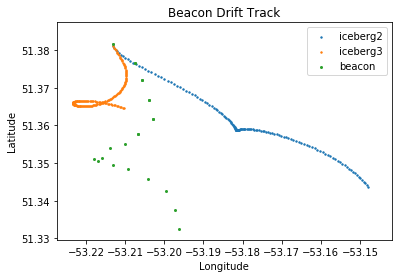

In [99]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]
beacon_metadata = pd.read_csv(dir_path + metadata_filename)

def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

df = get_df(dir_path, csv_filenames[1])

def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
            
    return berg

df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

start_time = np.datetime64(df.DataDate_UTC[start_index])
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

end_time = np.datetime64(df.DataDate_UTC[end_index])

ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

for i in range(end_index - start_index + 2):

    ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
    ref_berg.latitude = df.Latitude[start_index + i]
    ref_berg.longitude = df.Longitude[start_index + i]
    ref_berg.update_history()

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds()
#nt = int((end_time - start_time) / time_step)

time_info = (time_step, end_time)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

meto = metocean.Metocean((start_time, end_time))

berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

In [101]:
meto = metocean.Metocean((start_time, end_time))
berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)

In [103]:
min(berg.history['latitude']), max(berg.history['latitude'])

(51.343770708190625, 51.38151)

In [136]:
berg_lat_bounds = (min(berg.history['latitude']), max(berg.history['latitude']))
berg_lon_bounds = (min(berg.history['longitude']), max(berg.history['longitude']))
lat_bounds = (berg_lat_bounds[0] - 0.25, berg_lat_bounds[1] + 0.25)
lon_bounds = (berg_lon_bounds[0] - 0.25, berg_lon_bounds[1] + 0.25)
#lon_bounds = (-51, -49)
time_bounds = (start_time, end_time)

ocean_lat_idxs = np.where((meto.ocean.dataset.latitude > lat_bounds[0]) & \
                          (meto.ocean.dataset.latitude < lat_bounds[1]))[0]
ocean_lon_idxs = np.where((meto.ocean.dataset.longitude > lon_bounds[0]) & \
                          (meto.ocean.dataset.longitude < lon_bounds[1]))[0]
ocean_time_idxs = np.where((meto.ocean.dataset.time > time_bounds[0]) & \
                          (meto.ocean.dataset.time < time_bounds[1]))[0]
atm_lat_idxs = np.where((meto.atmosphere.dataset.lat > lat_bounds[0]) & \
                          (meto.atmosphere.dataset.lat < lat_bounds[1]))[0]
atm_lon_idxs = np.where((meto.atmosphere.dataset.lon > lon_bounds[0]) & \
                          (meto.atmosphere.dataset.lon < lon_bounds[1]))[0]
atm_time_idxs = np.where((meto.atmosphere.dataset.time > time_bounds[0]) & \
                          (meto.atmosphere.dataset.time < time_bounds[1]))[0]

uo = meto.ocean.eastward_current_velocities[ocean_time_idxs[0]:ocean_time_idxs[-1]+1, 
                                           ocean_lat_idxs[0]:ocean_lat_idxs[-1]+1,
                                           ocean_lon_idxs[0]:ocean_lon_idxs[-1]+1]

vo = meto.ocean.northward_current_velocities[ocean_time_idxs[0]:ocean_time_idxs[-1]+1, 
                                           ocean_lat_idxs[0]:ocean_lat_idxs[-1]+1,
                                           ocean_lon_idxs[0]:ocean_lon_idxs[-1]+1]

wo = np.sqrt(uo**2 + vo**2)

ua = meto.atmosphere.eastward_wind_velocities[atm_time_idxs[0]:atm_time_idxs[-1]+1,
                                             atm_lat_idxs[0]:atm_lat_idxs[-1]+1,
                                             atm_lon_idxs[0]:atm_lon_idxs[-1]+1]

va = meto.atmosphere.northward_wind_velocities[atm_time_idxs[0]:atm_time_idxs[-1]+1,
                                             atm_lat_idxs[0]:atm_lat_idxs[-1]+1,
                                             atm_lon_idxs[0]:atm_lon_idxs[-1]+1]

wa = np.sqrt(ua**2 + va**2)

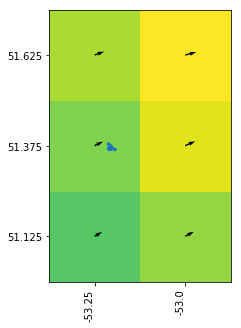

In [166]:
berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), meto, time_info)
fig, ax = plt.subplots(figsize=(10,5))
#ax.imshow(wa[0,:,:])
#xx, yy = np.mgrid[wa.longitude.values[0] : wa.longitude.values[-1] + np.mean(np.diff(wa.longitude.values)) : \
#                np.mean(np.diff(wa.longitude.values)),
#                wa.latitude.values[0] : wa.latitude.values[-1] + np.mean(np.diff(wa.latitude.values)) : \
#                np.mean(np.diff(wa.latitude.values))]
#ax.pcolor(xx, yy, wa[0,:,:])
dlon = np.mean(np.diff(wa.longitude.values))
dlat = np.mean(np.diff(wa.latitude.values))
extent = [wa.longitude[0] - dlon/2, wa.longitude[-1] + dlon/2, 
                       wa.latitude[0] - dlat/2, wa.latitude[-1] + dlat/2]
im = ax.imshow(wa[0,:,:], 
               extent=extent,
               origin='lower', vmin=min(wa.values.flatten()), vmax=max(wa.values.flatten()))
#xx, yy = np.mgrid[lon_bounds[0]:lon_bounds[1]:1/4, lat_bounds[0]:lat_bounds[1]:1/4]
#im = ax.pcolor(xx, yy, wa[0,:,:])
#plt.colorbar(im)

#ax.set_xticks(np.arange(0, len(wa.longitude), 2))
ax.set_xticks(wa.longitude.values)
ax.set_xticklabels(wa.longitude.values)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#ax.set_yticks(np.arange(0, len(wa.latitude), 2))
ax.set_yticks(wa.latitude.values)
ax.set_yticklabels(wa.latitude.values)
ax.quiver(wa.longitude.values, wa.latitude.values, ua[0,:,:], va[0,:,:])
#line, = ax.(x[0], y[0], c='red')
#scat = ax.scatter(x[0], y[0], c='red')
ax.scatter(berg.history['longitude'], berg.history['latitude'], s=2)

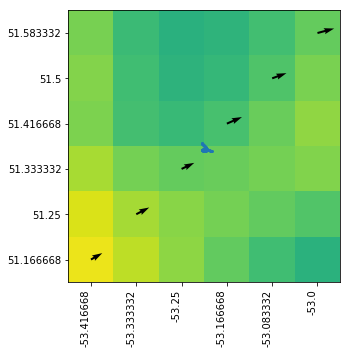

In [168]:
fig, ax = plt.subplots(figsize=(10,5))
#ax.imshow(wo[0,:,:])
#xx, yy = np.mgrid[wo.longitude.values[0] : wo.longitude.values[-1] + np.mean(np.diff(wo.longitude.values)) : \
#                np.mean(np.diff(wo.longitude.values)),
#                wo.latitude.values[0] : wo.latitude.values[-1] + np.mean(np.diff(wo.latitude.values)) : \
#                np.mean(np.diff(wo.latitude.values))]
#ax.pcolor(xx, yy, wo[0,:,:])
dlon = np.mean(np.diff(wo.longitude.values))
dlat = np.mean(np.diff(wo.latitude.values))
extent = [wo.longitude[0] - dlon/2, wo.longitude[-1] + dlon/2, 
                       wo.latitude[0] - dlat/2, wo.latitude[-1] + dlat/2]
im = ax.imshow(wo[0,:,:], 
               extent=extent,
               origin='lower', vmin=min(wo.values.flatten()), vmax=max(wo.values.flatten()))
#xx, yy = np.mgrid[lon_bounds[0]:lon_bounds[1]:1/4, lat_bounds[0]:lat_bounds[1]:1/4]
#im = ax.pcolor(xx, yy, wo[0,:,:])
#plt.colorbar(im)

#ax.set_xticks(np.arange(0, len(wo.longitude), 2))
ax.set_xticks(wo.longitude.values)
ax.set_xticklabels(wo.longitude.values)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')
#ax.set_yticks(np.arange(0, len(wo.latitude), 2))
ax.set_yticks(wo.latitude.values)
ax.set_yticklabels(wo.latitude.values)
ax.quiver(wo.longitude.values, wo.latitude.values, ua[0,:,:], va[0,:,:])
#line, = ax.(x[0], y[0], c='red')
#scat = ax.scatter(x[0], y[0], c='red')
ax.scatter(berg.history['longitude'], berg.history['latitude'], s=2)